# Uniqueness based on place365 scenes

In [1]:
import torch
import torchvision

import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt

from src.dataset import AirbnbDataset


def print_w_scenes(uniqueness, indices=None, scene="bedroom", most_unique=1000, most_common=None, seed=42):
    np.random.seed(seed)
    
    ## get top-k unique images
    if indices is None:
        uniqueness = uniqueness[uniqueness["scene"]==scene]    
        if most_unique is not None:
            samples = uniqueness.nsmallest(most_unique, columns=["loss"])
        if most_common is not None:
            samples = uniqueness.nlargest(most_common, columns=["loss"])
        indices = np.random.choice(samples.index.tolist(),30,replace=False)
    else:
        samples = uniqueness.reindex(indices)

    # load the test image
    inpath = "/export/projects2/szhang_text_project/Airbnb_unique/photo_library/"
    ds = AirbnbDataset(inpath)
    mapping = ds.idx_mapping.reset_index().set_index("image_id")

    prefix = "most common in" if most_common else "most unique in"
    print(f"{prefix} scene: {scene}")
    rows = int(len(indices) // 10)
    fig = plt.figure(figsize=(20, 3 * rows -1))
    for i, it in enumerate(indices):
        ax = fig.add_subplot(rows, 10, i+1)
        idx = mapping.loc[it]["index"]
        img = ds[idx]["image"].reshape(224, 224, 3).astype('uint8')

        # plot
        plt.imshow(img)
        if samples.shape[1] > 1:
            ax.set_title(f"{it} score:{samples.iloc[i,0]:.1f}")
        else:
            ax.set_title(f"score:{samples.iloc[i,0]:.1f}")
        plt.axis('off')
        plt.tight_layout()

        

In [2]:
## uniqueness file
file_path="./output/06-22_19:15:53/"
uniqueness = pd.read_pickle(file_path + "/uniqueness.pkl")

most unique in scene: bedroom


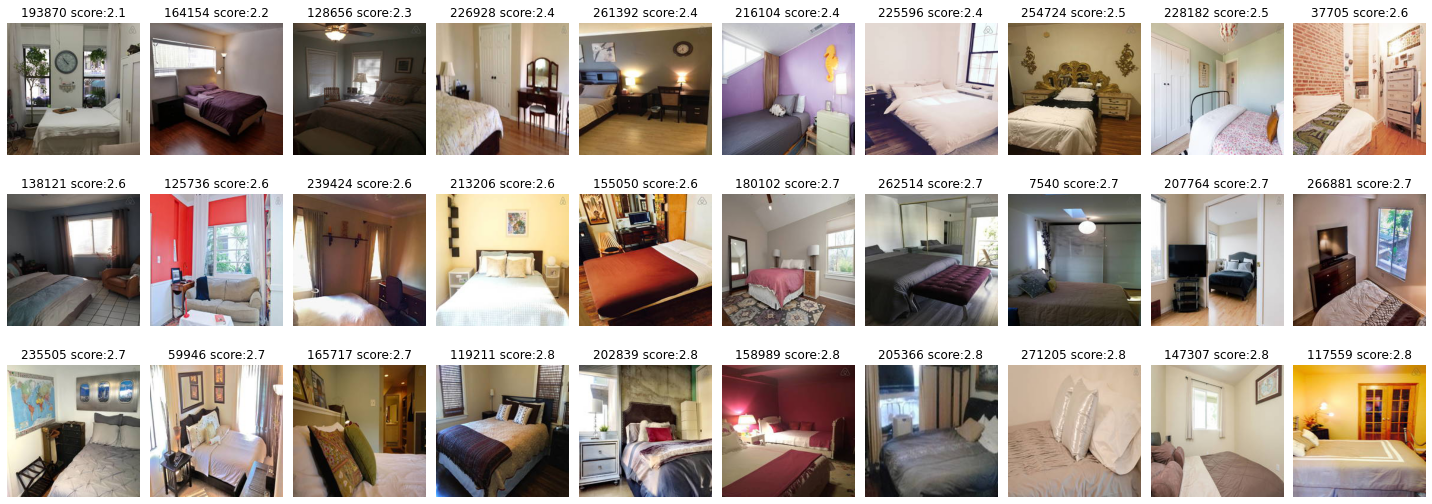

In [3]:
print_w_scenes(uniqueness, scene="bedroom", most_unique=5000, most_common=None, seed=1)

most common in scene: bedroom


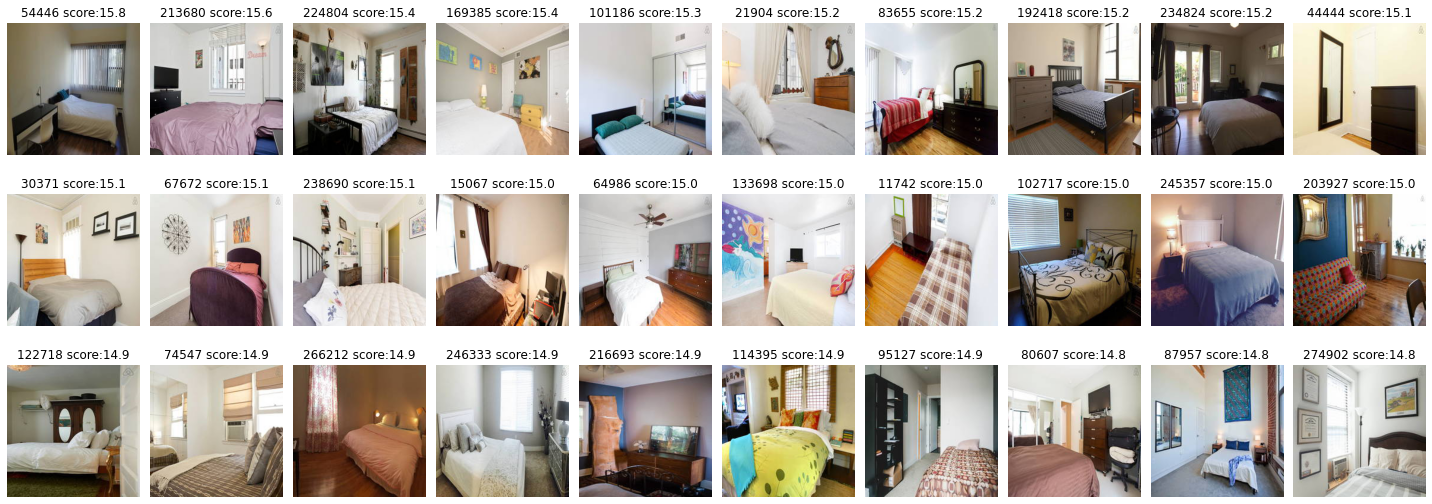

In [4]:
print_w_scenes(uniqueness, scene="bedroom", most_unique=None, most_common=30000, seed=1)

# Show where is unique

In [11]:
import argparse
import json
import os
from datetime import datetime

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F


from PIL import Image, ImageFile
from tqdm import tqdm
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

import src.model
import src.dataset

ImageFile.LOAD_TRUNCATED_IMAGES = True
device = "cuda" if torch.cuda.is_available() else "cpu"

def set_seed(seed=42, cuda_deterministic=True):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    if cuda_deterministic:  # slower, more reproducible
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    else:  # faster, less reproducible
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True


def load_state_dict_unsafe(model, state_dict):
    """
    Load state dict to provided model while ignore exceptions.
    """

    missing_keys = []
    unexpected_keys = []
    error_msgs = []

    # copy state_dict so _load_from_state_dict can modify it
    metadata = getattr(state_dict, "_metadata", None)
    state_dict = state_dict.copy()
    if metadata is not None:
        state_dict._metadata = metadata

    def load(module, prefix=""):
        local_metadata = {} if metadata is None else metadata.get(prefix[:-1], {})
        module._load_from_state_dict(
            state_dict,
            prefix,
            local_metadata,
            True,
            missing_keys,
            unexpected_keys,
            error_msgs,
        )
        for name, child in module._modules.items():
            if child is not None:
                load(child, prefix + name + ".")

    load(model)
    load = None  # break load->load reference cycle

    return {
        "unexpected_keys": unexpected_keys,
        "missing_keys": missing_keys,
        "error_msgs": error_msgs,
    }


class RELAX(nn.Module):
    def __init__(self, x, f, num_batches, batch_size):
        super().__init__()

        self.batch_size = batch_size
        self.shape = tuple(x.shape[2:])
        self.num_batches = num_batches
        self.pdist = nn.CosineSimilarity(dim=1)

        self.x = x
        self.encoder = f
        h_star = f(self.x)
        self.h_star = h_star.expand(batch_size, -1)

        self.R = torch.zeros(self.shape, device=device)
        self.U = torch.zeros(self.shape, device=device)

        self.sum_of_weights = (1e-10)*torch.ones(self.shape, device=device)

    def forward(self):

        for batch in range(self.num_batches):
            for masks in self.mask_generator():

                x_mask = self.x * masks
                h = self.encoder(x_mask)
                sims = self.pdist(self.h_star, h)

                for si, mi in zip(sims, masks.squeeze()):

                    W_prev = self.sum_of_weights
                    self.sum_of_weights += mi

                    R_prev = self.R.clone()
                    self.R = self.R + mi*(si-self.R) / self.sum_of_weights
                    self.U = self.U + (si-self.R) * (si-R_prev) * mi

        return None

    def importance(self):
        return self.R

    def uncertainty(self):
        return self.U / (self.sum_of_weights - 1)

    def mask_generator(self, num_cells=7, p=0.5, nsd=2):

        pad_size = (num_cells // 2, num_cells // 2, num_cells // 2, num_cells // 2)

        grid = (torch.rand(self.batch_size, 1, *((num_cells,) * nsd), device=device) < p).float()
        grid_up = F.interpolate(grid, size=(self.shape), mode='bilinear', align_corners=False)
        grid_up = F.pad(grid_up, pad_size, mode='reflect')

        shift_x = torch.randint(0, num_cells, (self.batch_size,), device=device)
        shift_y = torch.randint(0, num_cells, (self.batch_size,), device=device)

        masks = torch.empty((self.batch_size, 1, self.shape[-2], self.shape[-1]), device=device)

        for bi in range(self.batch_size):
            masks[bi] = grid_up[bi, :,
                                shift_x[bi]:shift_x[bi] + self.shape[-2],
                                shift_y[bi]:shift_y[bi] + self.shape[-1]]

        yield masks
        
        
def get_RELAX_list(uniqueness, model, indices, scene, most_unique, most_common, seed):
    
    np.random.seed(seed)
    ## get top-k unique images
    if indices is None:
        uniqueness = uniqueness[uniqueness["scene"]==scene]    
        if most_unique is not None:
            samples = uniqueness.nsmallest(most_unique, columns=["loss"])
        if most_common is not None:
            samples = uniqueness.nlargest(most_common, columns=["loss"])
        indices = np.random.choice(samples.index.tolist(),30,replace=False)
    else:
        samples = uniqueness.reindex(indices)

    ## dataset
    inpath = "/export/projects2/szhang_text_project/Airbnb_unique/photo_library/"
    ds = src.dataset.AirbnbDataset(inpath)
    mapping = ds.idx_mapping.reset_index().set_index("image_id")

    ## inference
    relax_list = []
    tsfm_imgs, raw = [], []
    mask_bs = 100
    num_batches = 30

    for idx in tqdm(indices):
        x = ds[mapping.loc[idx]["index"]]["image"]
        # raw.append(x)
        tsfm = torchvision.transforms.Compose([
            torchvision.transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ])
        x = tsfm(torchvision.transforms.ToPILImage()(x)).reshape(1, 3, 224, 224)
        tsfm_imgs.append(x)

        with torch.no_grad():

            relax = RELAX(x, model, num_batches, mask_bs)
            relax.forward()

        relax_list.append(relax)
        
    return relax_list, tsfm_imgs, indices
    
        
def show_RELAX(uniqueness, model, indices=None, scene="bedroom", most_unique=1000, most_common=None, seed=42):
    relax_list, tsfm_imgs, indices = get_RELAX_list(uniqueness, model, indices, scene, most_unique, most_common, seed)
    def to_np(x):
        return x.cpu().detach().numpy()

    def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
        if isinstance(img, Image.Image):
            img = pil_to_tensor(img)
        handle = None
        with torch.no_grad():
            if not lim:
                lim = [img.min(), img.max()]
            img = img - lim[0]  # also makes a copy
            img.mul_(1 / (lim[1] - lim[0]))
            img = torch.clamp(img, min=0, max=1)
            if not quiet:
                bitmap = img.expand(3,
                            *img.shape[1:]).permute(1, 2, 0).cpu().numpy()
        return bitmap

    fig = plt.figure(1, figsize=(16, 8))
    font_size = 15

    gs = gridspec.GridSpec(6, 20)

    for i, (model_explanation, idx) in enumerate(zip(relax_list, indices)):

        ax = plt.subplot(gs[0:2, 2*(i):2*(1+i)])
        if i == 0: 
            ax.set_ylabel('Importance', fontsize=font_size)

        ax.imshow(imsc(tsfm_imgs[i].squeeze()))
        im = ax.imshow(to_np(model_explanation.importance()), alpha=0.75, cmap='bwr')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"score:{uniqueness.loc[idx][0]:.2f}", fontsize=font_size)

        ax = plt.subplot(gs[2:4, 2*(i):2*(1+i)])
        if i == 0: ax.set_ylabel('Uncertainty', fontsize=font_size)

        ax.imshow(imsc(tsfm_imgs[i].squeeze()))

        ax.imshow(to_np(model_explanation.uncertainty()), alpha=0.75, cmap='bwr')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(idx, fontsize=font_size)

        ax = plt.subplot(gs[4:6, 2*(i):2*(1+i)])
        if i == 0: ax.set_ylabel('Raw', fontsize=font_size)

        ax.imshow(imsc(tsfm_imgs[i].squeeze()))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(idx, fontsize=font_size)

    plt.tight_layout()

    cbar_ax = fig.add_axes([0.98, 0.05, 0.01, 0.86])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_ticks([])

    plt.tight_layout()
    plt.show()


In [12]:
## uniqueness file
file_path="./output/06-22_19:15:53/"
uniqueness = pd.read_pickle(file_path + "/uniqueness.pkl")

## load model
model = src.model.MoCo(torchvision.models.__dict__["resnet18"], K=65280)
res = load_state_dict_unsafe(
        model, torch.load(file_path + "/model.pt", map_location="cpu")
    )
model = model.encoder_q

In [13]:
idx_unique = pd.DataFrame({
    "bedroom": [232359, 75703, 116576, 107052, 202186, 124741, 87692, 188449, 67486, 188904,], # 6202, 85052, 176789
    "kitchen": [148648, 29793, 277132, 277133, 53389, 194923, 107029, 131661, 69220, 232910,], # 203816, 155314, 169978
    "living_room": [142919, 246183, 135923, 264789, 150468, 206439, 193079, 123320, 161760, 1146,], # 260709, 16461
    "bathroom": [239255, 150016, 156861, 118789, 190410, 5469, 250962, 49214, 239456, 141057], # 79213, 83542, 92562, 37333
})

idx_common = pd.DataFrame({
    "bedroom": [135672, 122707, 177854, 90052, 118115, 13778, 85378, 92242, 217740, 102639,], # 137376, 192357
    "kitchen": [102403, 67644, 68228, 197776, 87298, 214953, 111442, 181116, 140436, 271398],
    "living_room": [149200, 145519, 60846, 25825, 148479, 248706, 71801, 92272, 226489, 170549,], # 135893, 95399
    "bathroom": [232168, 278018, 44340, 254906, 181481, 113578, 209490, 83185, 259438, 176996],
})


most unique in scene: bedroom
most unique in scene: kitchen
most unique in scene: living_room
most unique in scene: bathroom


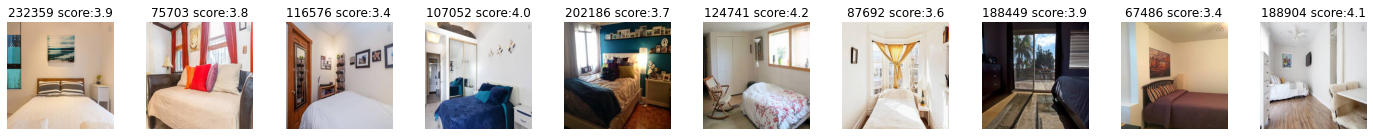

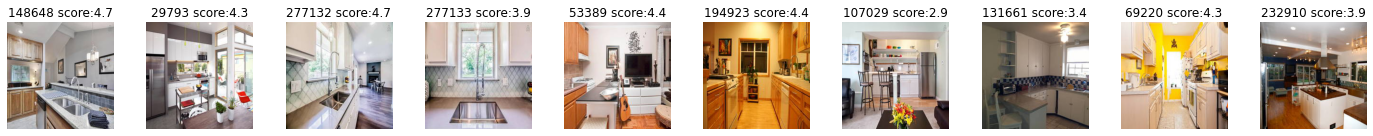

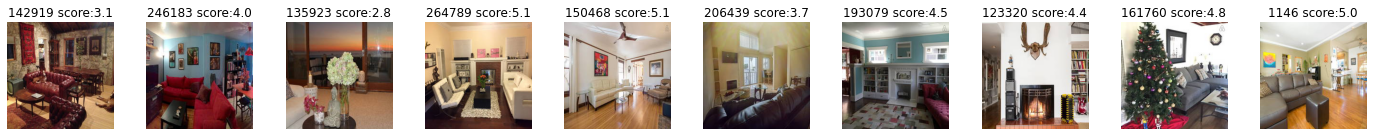

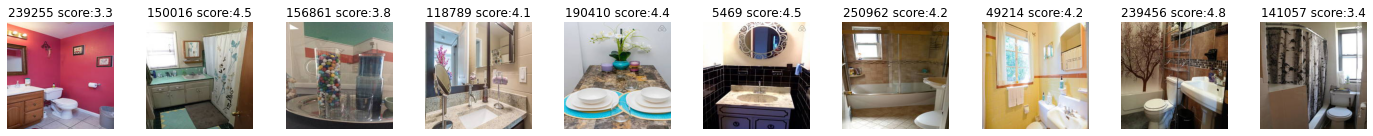

In [14]:
print_w_scenes(uniqueness, indices=idx_unique["bedroom"], scene="bedroom", most_unique=1000, most_common=None)
print_w_scenes(uniqueness, indices=idx_unique["kitchen"], scene="kitchen", most_unique=1000, most_common=None)
print_w_scenes(uniqueness, indices=idx_unique["living_room"], scene="living_room", most_unique=1000, most_common=None)
print_w_scenes(uniqueness, indices=idx_unique["bathroom"], scene="bathroom", most_unique=1000, most_common=None)


most common in scene: bedroom
most common in scene: kitchen
most common in scene: living_room
most common in scene: bathroom


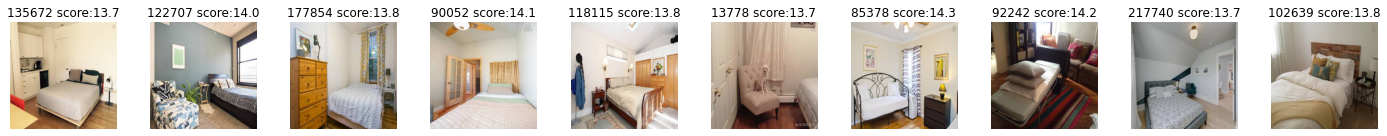

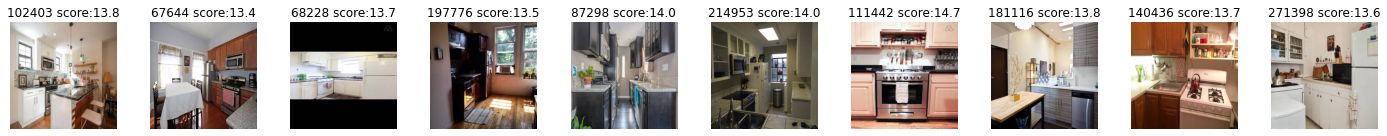

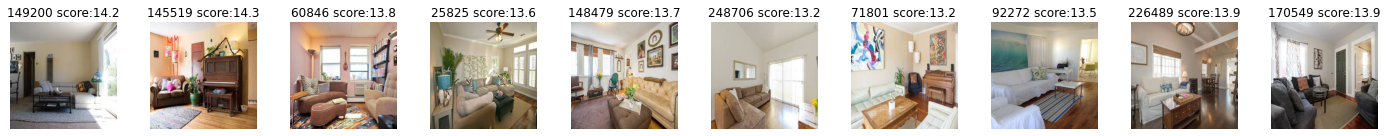

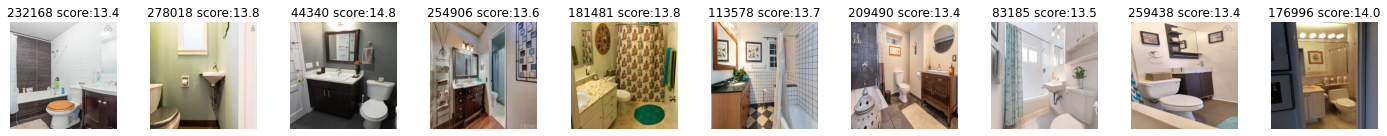

In [15]:
print_w_scenes(uniqueness, indices=idx_common["bedroom"], scene="bedroom", most_unique=None, most_common=1000)
print_w_scenes(uniqueness, indices=idx_common["kitchen"], scene="kitchen", most_unique=None, most_common=1000)
print_w_scenes(uniqueness, indices=idx_common["living_room"], scene="living_room", most_unique=None, most_common=1000)
print_w_scenes(uniqueness, indices=idx_common["bathroom"], scene="bathroom", most_unique=None, most_common=1000)


100%|██████████| 10/10 [06:29<00:00, 38.93s/it]
<ipython-input-11-fbcf2e176827>:253: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


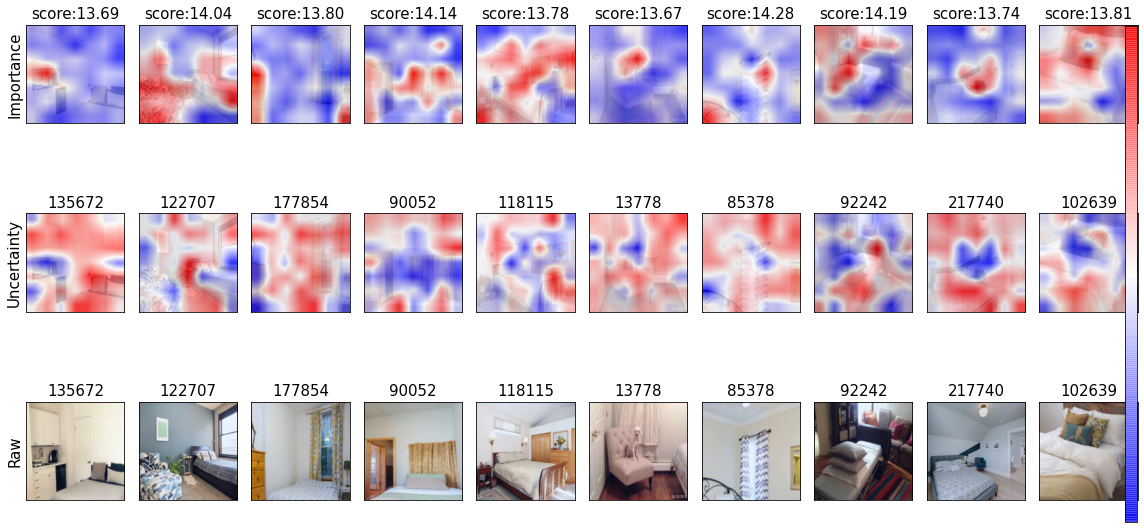

In [16]:
show_RELAX(uniqueness, model, indices=idx_common["bedroom"], scene="bedroom", most_unique=None, most_common=1000)

100%|██████████| 10/10 [06:31<00:00, 39.17s/it]
<ipython-input-11-fbcf2e176827>:253: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


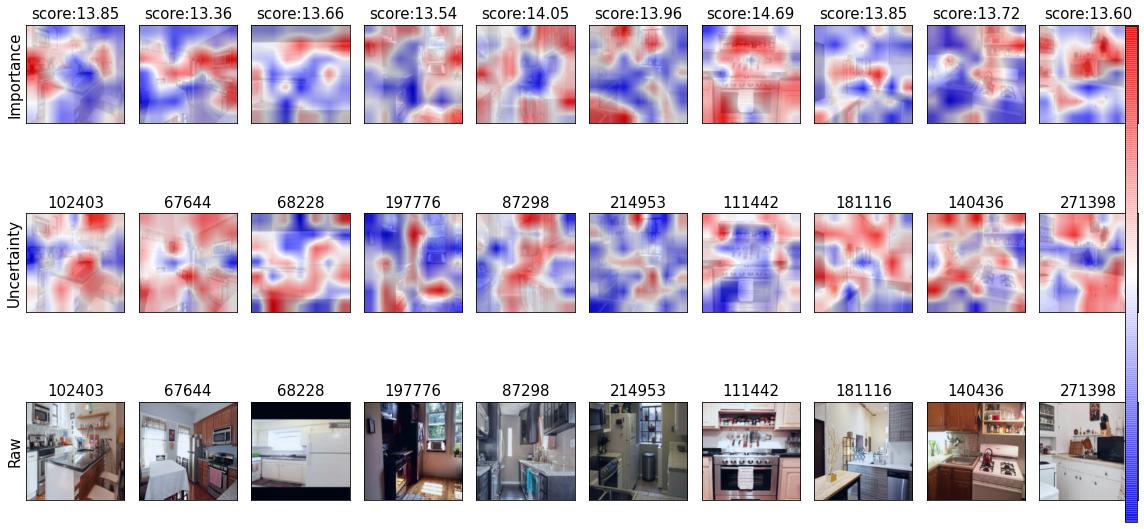

In [17]:
show_RELAX(uniqueness, model, indices=idx_common["kitchen"], scene="kitchen", most_unique=None, most_common=1000)

100%|██████████| 10/10 [06:31<00:00, 39.20s/it]
<ipython-input-11-fbcf2e176827>:253: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


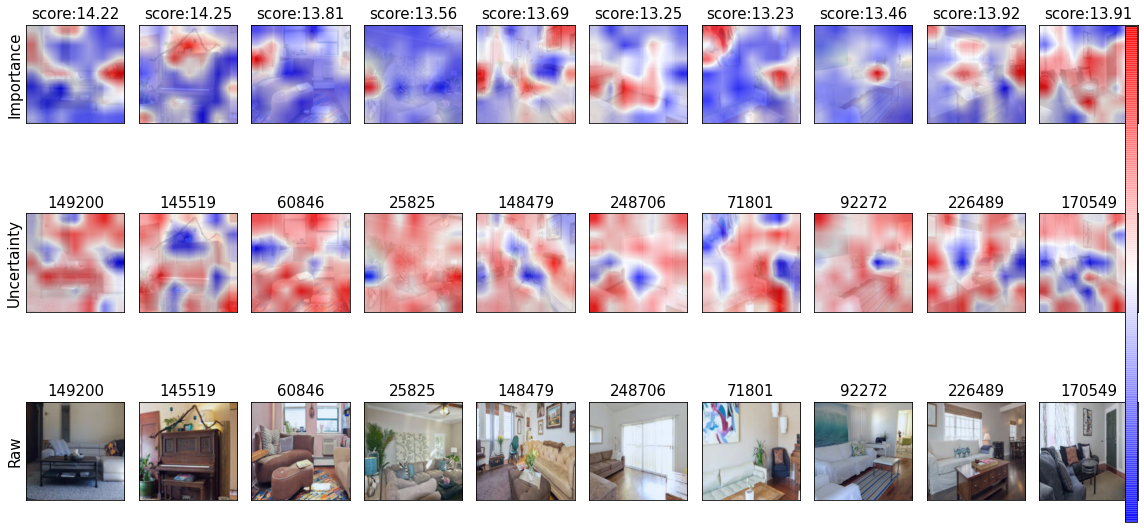

In [18]:
show_RELAX(uniqueness, model, indices=idx_common["living_room"], scene="living_room", most_unique=None, most_common=1000)

100%|██████████| 10/10 [06:32<00:00, 39.25s/it]
<ipython-input-11-fbcf2e176827>:253: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


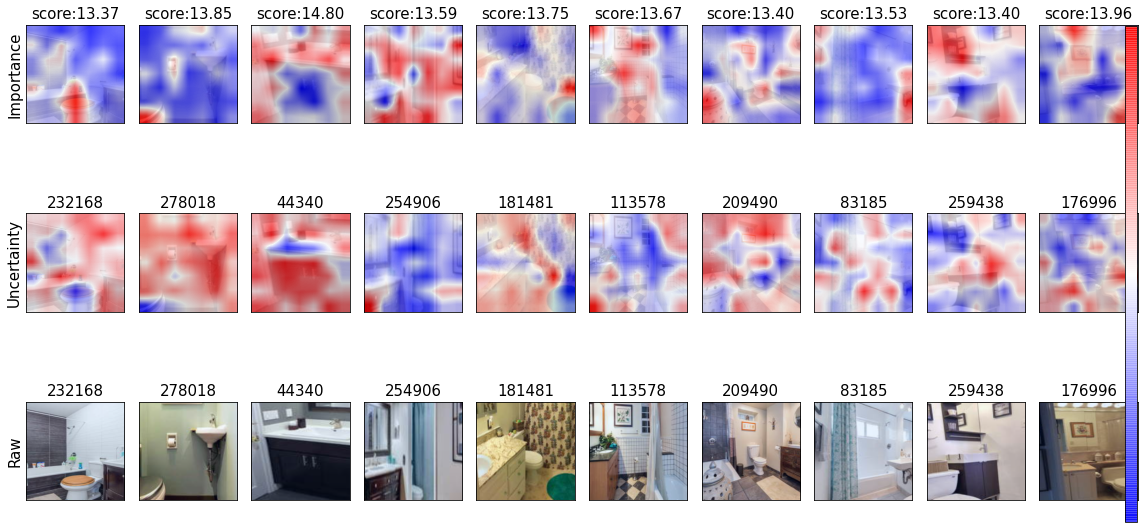

In [19]:
show_RELAX(uniqueness, model, indices=idx_common["bathroom"], scene="bathroom", most_unique=None, most_common=1000)

100%|██████████| 10/10 [06:31<00:00, 39.15s/it]
<ipython-input-11-fbcf2e176827>:253: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


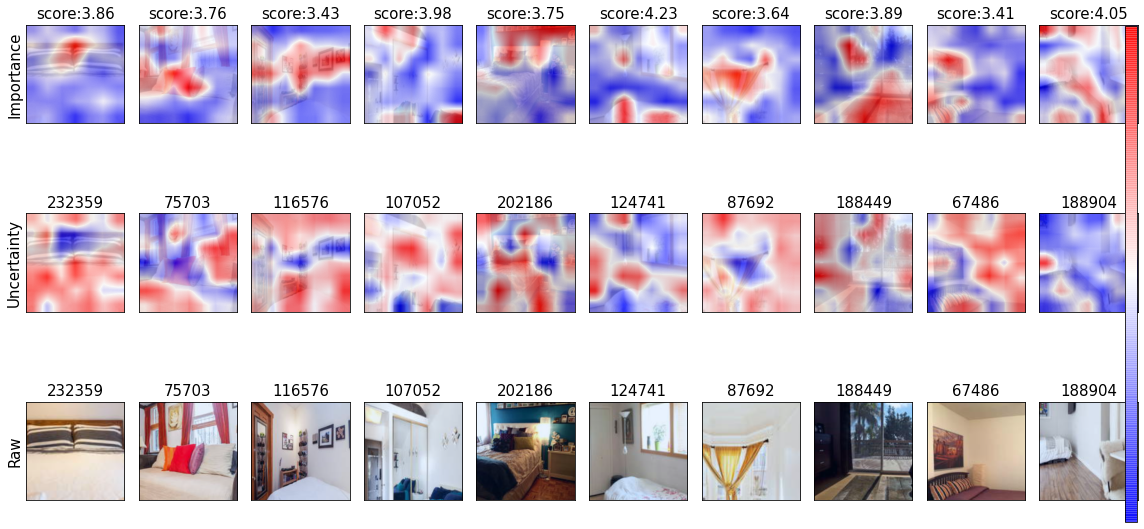

In [20]:
show_RELAX(uniqueness, model, indices=idx_unique["bedroom"], scene="bedroom", most_unique=1000, most_common=None)

100%|██████████| 10/10 [06:33<00:00, 39.30s/it]
<ipython-input-11-fbcf2e176827>:253: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


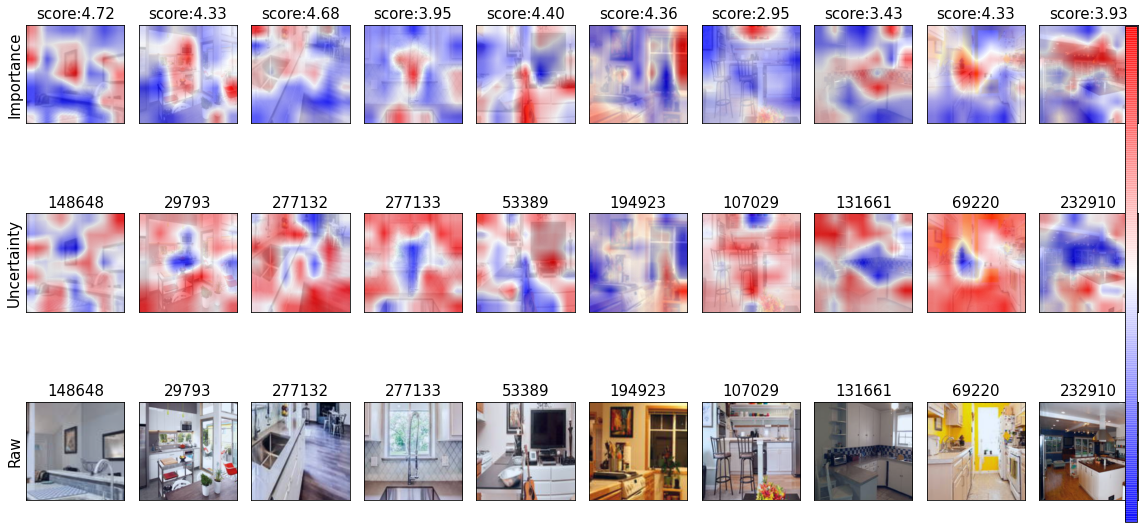

In [21]:
show_RELAX(uniqueness, model, indices=idx_unique["kitchen"], scene="kitchen", most_unique=1000, most_common=None)

100%|██████████| 10/10 [06:32<00:00, 39.26s/it]
<ipython-input-11-fbcf2e176827>:253: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


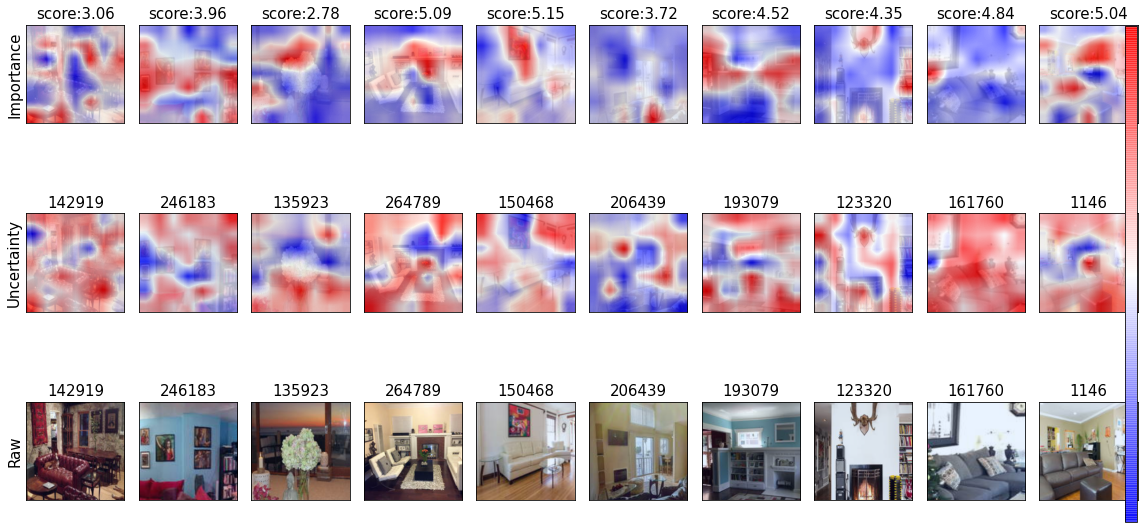

In [22]:
show_RELAX(uniqueness, model, indices=idx_unique["living_room"], scene="living_room", most_unique=1000, most_common=None)

In [ ]:
show_RELAX(uniqueness, model, indices=idx_unique["bathroom"], scene="bathroom", most_unique=1000, most_common=None)

 90%|█████████ | 9/10 [05:55<00:39, 39.52s/it]

# Analysis of Uniqueness

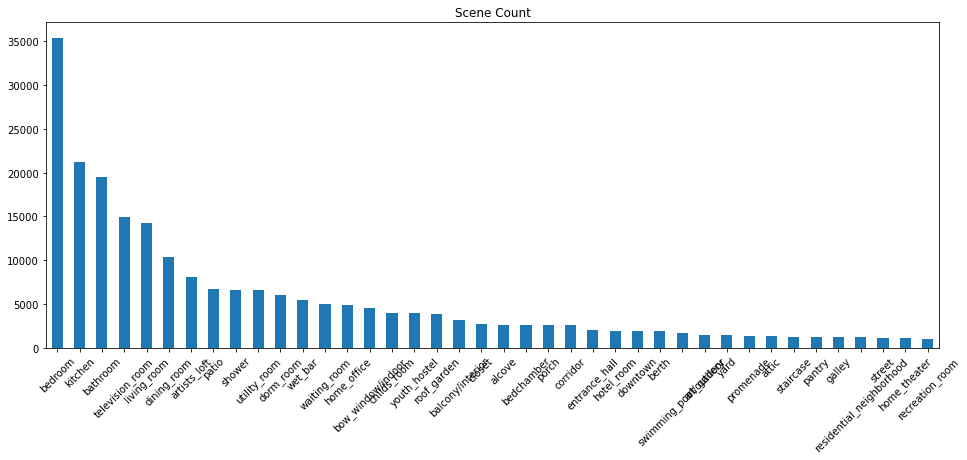

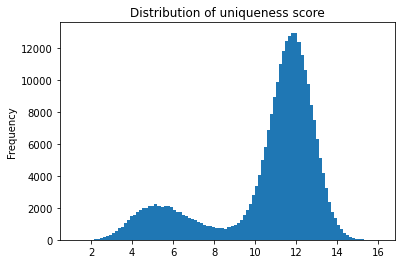

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## uniqueness file
file_path="./output/06-22_19:15:53/"
uniqueness = pd.read_pickle(file_path + "/uniqueness.pkl")

plt.figure(figsize=(16,6))
_ = uniqueness.iloc[:,2].value_counts()[:40].plot.bar(rot=45, title="Scene Count")
plt.figure()
_ = uniqueness.loss.plot.hist(bins=100,title="Distribution of uniqueness score")

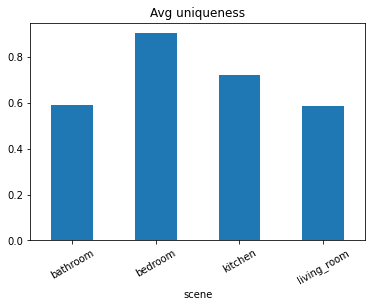

In [2]:
## Average uniqueness ranked by scenes
t = uniqueness.copy()
t["loss"] = t["loss"].sub(uniqueness.groupby("scene")["loss"].transform("mean"))
t = t.groupby("scene")["loss"].mean().rank(pct=True)
_ = t[t.index.isin(["bedroom","bathroom","living_room","kitchen"])].plot.bar(rot=30,title="Avg uniqueness")

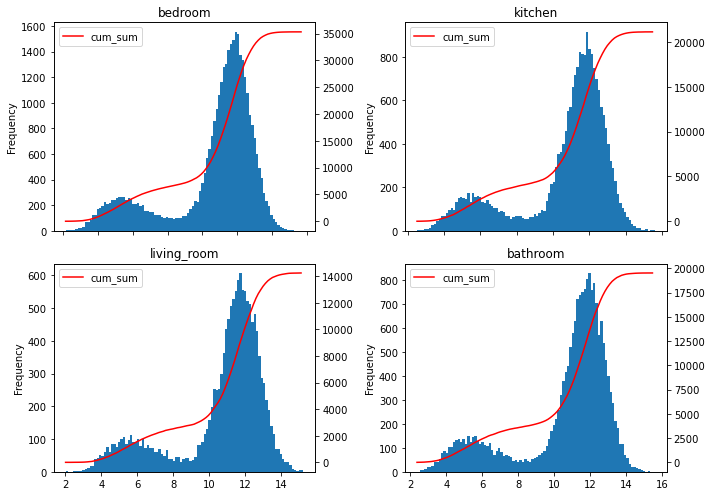

In [5]:
def plot_scene_dist(uniqueness, ax, scene="bedroom"):
    idx = uniqueness["scene"]==scene
    uniqueness[idx]["loss"].plot.hist(bins=100,title=scene,ax=ax)
    ax2 = ax.twinx()
    t = pd.cut(uniqueness[idx]["loss"],100).value_counts()
    t.index = [i.left for i in t.index]
    t.name = "cum_sum"
    t = t.sort_index()
    np.cumsum(t).plot(ax=ax2, color="r", legend=True)
    
    
fig,ax = plt.subplots(2,2,figsize=(10,7))
plot_scene_dist(uniqueness, ax[0,0], "bedroom")
plot_scene_dist(uniqueness, ax[0,1], "kitchen")
plot_scene_dist(uniqueness, ax[1,0], "living_room")
plot_scene_dist(uniqueness, ax[1,1], "bathroom")
plt.tight_layout()

In [6]:
print(t.sort_values())

scene
marsh             0.005525
soccer_field      0.005525
water_park        0.005525
lobby             0.011050
pavilion          0.013812
                    ...   
plaza             0.988950
alley             0.991713
yard              0.994475
elevator_lobby    0.997238
hardware_store    1.000000
Name: loss, Length: 362, dtype: float64
